### Housing DataSet Cleaning

Benny Cohen

10/26/2019

The Housing Maintenance Code Violations found at https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Violations/wvxf-dwi5 describes several housing violations found in NY and provides details including where the incident was, (broken down by boro, and address), how severe it was (broken down into 3 classes, A,B,C where A is least severe and C the most severe)

In this notebook we will prototype 3 of the ways we need to clean the data: deleting duplicate rows, changing datatypes, and dealing with missing data 

First we import needed packages and the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("https://data.cityofnewyork.us/resource/wvxf-dwi5.csv?$limit=50000")

Now let's see what the data looks like

In [3]:
df.shape

(50000, 40)

In [4]:
df.head(5)

,violationid,buildingid,registrationid,boroid,boro,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,...,novtype,violationstatus,latitude,longitude,communityboard,councildistrict,censustract,bin,bbl,nta
0,10000009,265980,301467,3,BROOKLYN,355,355,355,EAST 48 STREET,36930,...,Original,Close,40.653217,-73.932480,17.0,41.0,870.0,3102071.0,3.046740e+09,East Flatbush-Farragut
1,10000011,73852,226626,2,BRONX,1123,1123,1123,EAST TREMONT AVENUE,29620,...,Original,Close,40.839954,-73.876599,6.0,15.0,220.0,2042428.0,2.040040e+09,East Tremont
2,10000012,80102,211704,2,BRONX,751,751,751,GERARD AVENUE,35020,...,Original,Close,40.824692,-73.926605,4.0,8.0,63.0,2002971.0,2.024820e+09,West Concourse
3,10000014,268639,350942,3,BROOKLYN,54,54,54,EAST 52 STREET,37080,...,Original,Close,40.659731,-73.929295,17.0,41.0,878.0,3099672.0,3.046050e+09,Prospect Lefferts Gardens-Wingate
4,10000017,268167,300713,3,BROOKLYN,146,146,146,EAST 52 STREET,37080,...,Original,Close,40.657615,-73.929067,17.0,41.0,878.0,3100214.0,3.046210e+09,Prospect Lefferts Gardens-Wingate


First let's use the info method to see the columns count and data types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 40 columns):
violationid              50000 non-null int64
buildingid               50000 non-null int64
registrationid           50000 non-null int64
boroid                   50000 non-null int64
boro                     50000 non-null object
housenumber              50000 non-null object
lowhousenumber           49992 non-null object
highhousenumber          50000 non-null object
streetname               50000 non-null object
streetcode               50000 non-null int64
zip                      49998 non-null float64
apartment                41431 non-null object
story                    48094 non-null object
block                    50000 non-null int64
lot                      50000 non-null int64
class                    50000 non-null object
inspectiondate           50000 non-null object
approveddate             50000 non-null object
originalcertifybydate    49357 non-null object
orig

Let's make notes about things we need to correct. 

1. Missing data: We note that we had 50000 rows and see that since count ignores nulls that most of the columns contain all the info. Some don't though but we probably are not going to use all the columns anyways. Address information for example is missing data but those are specific columns that we probably wouldn't be able to get that much info about. We could drop that but it might be usefull to keep for if we want to see something like if multiple apartments in a building have violations. The new certify date fields are null for a lot of datapoints simply because data is only entered for them when postponements are granted. That is usefull data that we want to keep. The other fields we will look at later at the botumn of the notebook.

2. Datatypes: Date columns are going to need to be changed to datetime. We actually have no 'numeric' data because all of our numeric types are ids so there is no point in doing a df.describe to see numeric info.  It's fine to leave id column and codes as ints but we should verify if they are unique. 

In [6]:
df.violationid.value_counts().sort_values(ascending = False).head()

10946561    1
10149601    1
11296559    1
10106887    1
10093767    1
Name: violationid, dtype: int64

Since the violation ids are unique we don't need to join them and we know that each incident is unique.This seems somewhat odd though. One of the columns in the data frame is 'currentstatusid'. It seems weird to me that they would update a row when an incident has its status updated instead of just adding a new row. This is worth investigating... We can do a join on all the columns that make an incident unique. except for the columns indicating statuses. For now though, let's see if there are duplicate rows.  

In [7]:
pd.set_option('display.max_columns', 100)
joined = pd.merge(df,df, on = ['violationid'], how = 'inner')
joined.shape

(50000, 79)

So when we join on the id column we get all the rows as we expected... Now let's join without the id column. We should get the same output if there is no duplicate data. If there is duplicate data we are going to get extra rows since each row would map to a row on something more than itself.

In [9]:
joined = pd.merge(df,df, on = list(df.columns)[1:], how = 'inner')


In [10]:
sameviolation = joined[joined['violationid_x'] != joined['violationid_y']]

In [11]:
sameviolation.shape

(98, 41)

So 98 rows seem to contain duplicate data... Maybe let's look at them

In [12]:
sameviolation

,violationid_x,buildingid,registrationid,boroid,boro,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,zip,apartment,story,block,lot,class,inspectiondate,approveddate,originalcertifybydate,originalcorrectbydate,newcertifybydate,newcorrectbydate,certifieddate,ordernumber,novid,novdescription,novissueddate,currentstatusid,currentstatus,currentstatusdate,novtype,violationstatus,latitude,longitude,communityboard,councildistrict,censustract,bin,bbl,nta,violationid_y
1679,10005692,42588,124412,1,MANHATTAN,614,614,614,WEST 152 STREET,36810,10031.0,5,1,2098,43,B,2013-10-11T00:00:00.000,2013-10-16T00:00:00.000,2013-12-05T00:00:00.000,2013-11-21T00:00:00.000,NaN,NaN,NaN,508,4709407,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-17T00:00:00.000,19,VIOLATION CLOSED,2015-06-17T00:00:00.000,Original,Close,40.831085,-73.947813,9.0,7.0,237.0,1062459.0,1.020980e+09,Hamilton Heights,10005758
1680,10005758,42588,124412,1,MANHATTAN,614,614,614,WEST 152 STREET,36810,10031.0,5,1,2098,43,B,2013-10-11T00:00:00.000,2013-10-16T00:00:00.000,2013-12-05T00:00:00.000,2013-11-21T00:00:00.000,NaN,NaN,NaN,508,4709407,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-17T00:00:00.000,19,VIOLATION CLOSED,2015-06-17T00:00:00.000,Original,Close,40.831085,-73.947813,9.0,7.0,237.0,1062459.0,1.020980e+09,Hamilton Heights,10005692
2183,10007391,67195,200214,2,BRONX,246,246,246,EAST 199 STREET,27630,10458.0,2B,3,3302,42,B,2013-10-16T00:00:00.000,2013-10-18T00:00:00.000,2013-12-09T00:00:00.000,2013-11-25T00:00:00.000,NaN,NaN,NaN,569,4711037,SECTION 27-2018 ADMIN. CODE: ABATE THE NUISA...,2013-10-21T00:00:00.000,19,VIOLATION CLOSED,2015-03-17T00:00:00.000,Original,Close,40.870409,-73.887396,7.0,15.0,40702.0,2017092.0,2.033020e+09,Bedford Park-Fordham North,10007409
2184,10007409,67195,200214,2,BRONX,246,246,246,EAST 199 STREET,27630,10458.0,2B,3,3302,42,B,2013-10-16T00:00:00.000,2013-10-18T00:00:00.000,2013-12-09T00:00:00.000,2013-11-25T00:00:00.000,NaN,NaN,NaN,569,4711037,SECTION 27-2018 ADMIN. CODE: ABATE THE NUISA...,2013-10-21T00:00:00.000,19,VIOLATION CLOSED,2015-03-17T00:00:00.000,Original,Close,40.870409,-73.887396,7.0,15.0,40702.0,2017092.0,2.033020e+09,Bedford Park-Fordham North,10007391
2725,10009095,683226,413083,4,QUEENS,22-11,22-11,22-11,NEW HAVEN AVENUE,57090,11691.0,7G,7,15762,70,B,2013-10-16T00:00:00.000,2013-10-18T00:00:00.000,2013-12-09T00:00:00.000,2013-11-25T00:00:00.000,NaN,NaN,NaN,508,4711340,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-21T00:00:00.000,19,VIOLATION CLOSED,2014-09-23T00:00:00.000,Original,Close,40.601049,-73.756061,14.0,31.0,99801.0,4300994.0,4.157620e+09,Far Rockaway-Bayswater,10009130
2726,10009130,683226,413083,4,QUEENS,22-11,22-11,22-11,NEW HAVEN AVENUE,57090,11691.0,7G,7,15762,70,B,2013-10-16T00:00:00.000,2013-10-18T00:00:00.000,2013-12-09T00:00:00.000,2013-11-25T00:00:00.000,NaN,NaN,NaN,508,4711340,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-21T00:00:00.000,19,VIOLATION CLOSED,2014-09-23T00:00:00.000,Original,Close,40.601049,-73.756061,14.0,31.0,99801.0,4300994.0,4.157620e+09,Far Rockaway-Bayswater,10009095
3012,10409069,27624,121494,1,MANHATTAN,38,38,48,SICKLES STREET,30590,10040.0,3L,3,2174,125,A,2014-10-06T00:00:00.000,2014-10-07T00:00:00.000,2015-01-25T00:00:00.000,2015-01-11T00:00:00.000,NaN,NaN,NaN,502,4929986,SECTION 27-2005 ADM CODE PROPERLY REPAIR WITH...,2014-10-08T00:00:00.000,19,VIOLATION CLOSED,2018-10-07T00:00:00.000,Original,Close,40.861397,-73.927826,12.0,10.0,285.0,1064191.0,1.021740e+09,Washington Heights North,10409093
3013,10409093,27624,121494,1,MANHATTAN,38,38,48,SICKLES STREET,30590,10040.0,3L,3,2174,125,A,2014-10-06T00:00:00.000,2014-10-07T00:00:00.000,2015-01-25T00:00:00.000,2015-01-11T00:00:00.000,NaN,NaN,NaN,502,4929986,SECTION 27-2005 ADM CODE PROPERLY REPAIR WITH...,2014-10-08T00:00:00.000,19,VIOLATION CLOSED,2018-10-07T00:00:00.000,Original,Close,40.861397,-73.927826,12.0,10.0,285.0,1064191.0,1.021740e+09,Washington Heights North,10409069
575

In [157]:
#One sample row
df[df['violationid'] == 10005692]

,violationid,buildingid,registrationid,boroid,boro,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,zip,apartment,story,block,lot,class,inspectiondate,approveddate,originalcertifybydate,originalcorrectbydate,newcertifybydate,newcorrectbydate,certifieddate,ordernumber,novid,novdescription,novissueddate,currentstatusid,currentstatus,currentstatusdate,novtype,violationstatus,latitude,longitude,communityboard,councildistrict,censustract,bin,bbl,nta
1678,10005692,42588,124412,1,MANHATTAN,614,614,614,WEST 152 STREET,36810,10031.0,5,1,2098,43,B,2013-10-11T00:00:00.000,2013-10-16T00:00:00.000,2013-12-05T00:00:00.000,2013-11-21T00:00:00.000,NaN,NaN,NaN,508,4709407,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-17T00:00:00.000,19,VIOLATION CLOSED,2015-06-17T00:00:00.000,Original,Close,40.831085,-73.947813,9.0,7.0,237.0,1062459.0,1.020980e+09,Hamilton Heights


In [158]:
df[df['violationid'] == 10005758]

,violationid,buildingid,registrationid,boroid,boro,housenumber,lowhousenumber,highhousenumber,streetname,streetcode,zip,apartment,story,block,lot,class,inspectiondate,approveddate,originalcertifybydate,originalcorrectbydate,newcertifybydate,newcorrectbydate,certifieddate,ordernumber,novid,novdescription,novissueddate,currentstatusid,currentstatus,currentstatusdate,novtype,violationstatus,latitude,longitude,communityboard,councildistrict,censustract,bin,bbl,nta
1701,10005758,42588,124412,1,MANHATTAN,614,614,614,WEST 152 STREET,36810,10031.0,5,1,2098,43,B,2013-10-11T00:00:00.000,2013-10-16T00:00:00.000,2013-12-05T00:00:00.000,2013-11-21T00:00:00.000,NaN,NaN,NaN,508,4709407,SECTION 27-2005 ADM CODE REPAIR THE BROKEN OR...,2013-10-17T00:00:00.000,19,VIOLATION CLOSED,2015-06-17T00:00:00.000,Original,Close,40.831085,-73.947813,9.0,7.0,237.0,1062459.0,1.020980e+09,Hamilton Heights


Are these really duplicates? Maybe something is unique about them? Maybe there is a field missing from the data? Maybe it's a collection problem?

Text(0.5, 1.0, 'Incidents per boro')

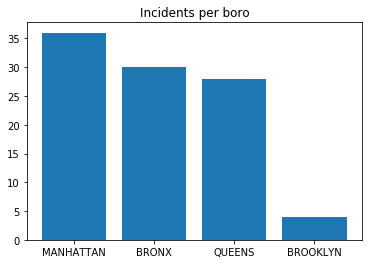

In [24]:
plt.bar(sameviolation['boro'].unique(), sameviolation['boro'].value_counts())
plt.title("Incidents per boro")

I don't know. Let's drop them since we have enough data anyways...

In [14]:
df = df.set_index('violationid').sort_index() #might as well if we are treating these as ids....

In [15]:
df = df.drop(sameviolation.violationid_x)

In [16]:
df.shape

(49902, 39)

Okay... We are going to have to play with the same process to see if the same incidents are being repeated when there status is being updated but for times sake let's do more cleaning. Let's show as a sample how we can convert our datatypes...

In [17]:
df['currentstatusdate'] = pd.to_datetime(df['currentstatusdate'])
df['inspectiondate'] = pd.to_datetime(df['inspectiondate'])

In [18]:
df.inspectiondate.dtype

dtype('<M8[ns]')

We see that they it is now a datetime (That is a datetime type). I'm not going to do all of them now since I don't know which ones I'm going to need. 
The last thing I want to adress are nulls. Like I said earlier, address fields and certify dates we are going to want to keep. Let's look at the other columns...

In [19]:
nullBin = df[df['bin'].isnull()]

In [20]:
nullBin.shape

(82, 39)

Bin is the building identification number... We might be able to get these values and fill them in with some playing around

In [21]:
nullBin.buildingid.value_counts()

64078     27
804923    10
811557     8
807587     6
809077     6
809571     5
727780     4
66112      4
803906     2
855030     1
812433     1
808087     1
853400     1
883013     1
1869       1
601423     1
811461     1
643298     1
809101     1
Name: buildingid, dtype: int64

The ones that have only 1 entry we probably can look up manually online if we really need them. Let's see if we can find the building id for the other ones though and just map them.

In [22]:
df[df['buildingid'] == 64078].shape

(27, 39)

On second thought we don't need this column anyways since we have a unique building id anyways. Let's drop it

In [23]:
df = df.drop('bin', axis = 1)
df.shape

(49902, 38)